In [1]:
import sys
import json
from IPython import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# parent directory to work with dev
sys.path.insert(0, '..')
import verifyml.model_card_toolkit as mctlib
from verifyml.model_card_toolkit import model_card_pb2, ModelCard
from verifyml.model_card_toolkit.utils.tally_form import tally_form_to_mc
from verifyml.model_tests.utils import plot_to_str
from verifyml.model_tests.FEAT import (
    SubgroupDisparity,
    MinMaxMetricThreshold,
)

## Read output with truth and prediction columns

In [2]:
# Read output
# truth column -> total no. of words spoken by the individual
# prediction column -> total no. of words correctly transcribed by google's speech to text model model

output = pd.read_csv("../data/speech_sample_output.csv")
output.rename(columns={'truth_count':'truth', 'match_count':'prediction'},inplace=True)
mse_test = round(mean_squared_error(output.truth, output.prediction),3)
mae_test = round(mean_absolute_error(output.truth, output.prediction), 3)




In [3]:
output

,sex,race,truth,prediction
0,F,CHINESE,77,60
1,F,CHINESE,84,64
2,M,CHINESE,80,53
3,F,INDIAN,80,53
4,M,CHINESE,70,45
...,...,...,...,...
293,M,CHINESE,74,50
294,M,MALAY,68,52
295,F,CHINESE,82,58
296,F,CHINESE,79,52


## Word count plot

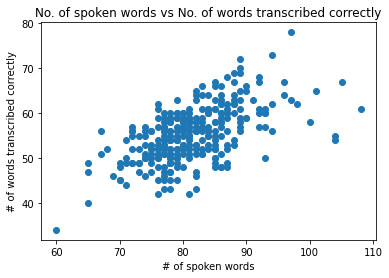

In [4]:
plt.scatter(output.truth, output.prediction)
plt.xlabel('# of spoken words')
plt.ylabel('# of words transcribed correctly')
plt.title('No. of spoken words vs No. of words transcribed correctly')
word_match_plot = plot_to_str()


## Analysing model perfomance

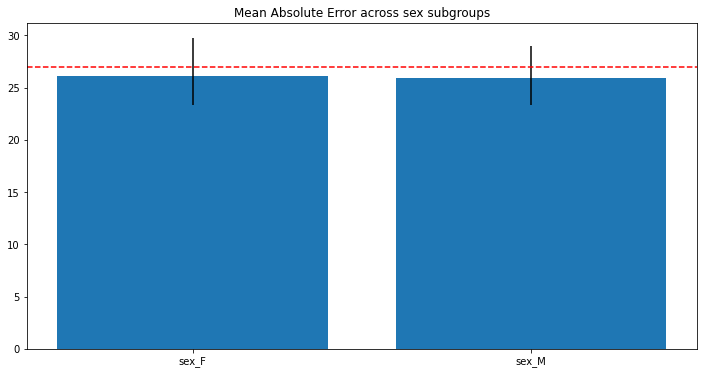

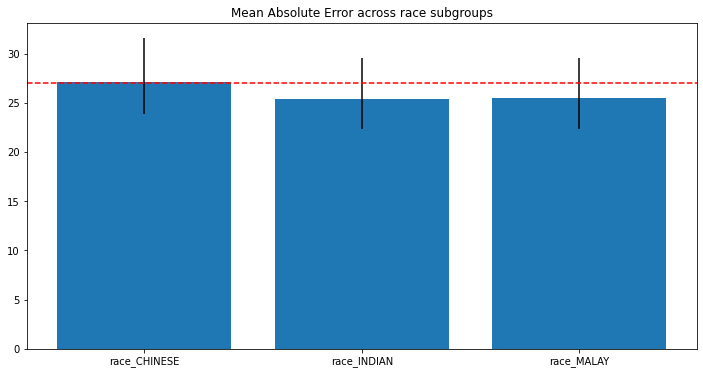

In [5]:
# ROC/Min Max Threshold Test

threshold_test_gender = MinMaxMetricThreshold(
    #test_name="",        # Default test name and description will be used accordingly if not specified
    #test_desc="",
    attr="sex",
    metric="mae",
    threshold=27,
)
threshold_test_gender.run(df_test_with_output=output)
threshold_test_gender.plot(alpha=0.05)

threshold_test_race = MinMaxMetricThreshold(
    attr="race",
    metric="mae",
    threshold=27,
)
threshold_test_race.run(df_test_with_output=output)
threshold_test_race.plot(alpha=0.05)

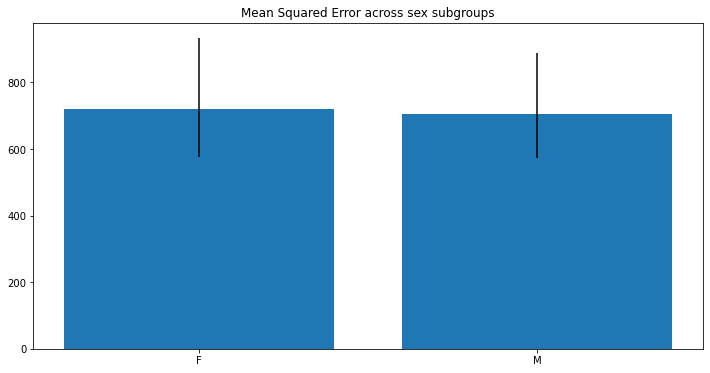

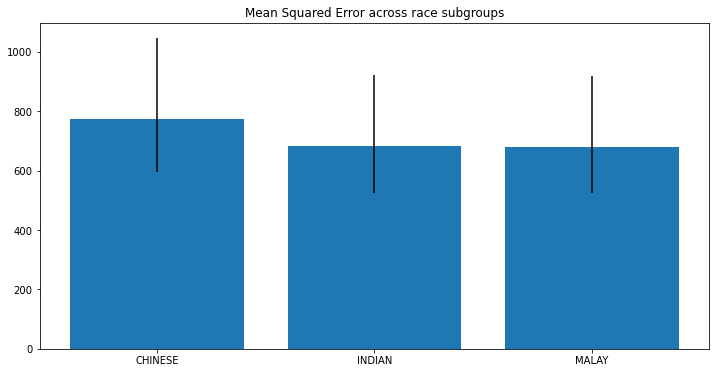

In [6]:
# Subgroup Disparity Test

sgd_test_gender = SubgroupDisparity(
    attr='sex',
    metric='mse',
    method='ratio',
    threshold=1.1,
)
sgd_test_gender.run(output)
sgd_test_gender.plot(alpha=0.05)     # default alpha argument shows 95% C.I bands

sgd_test_race = SubgroupDisparity(
    attr='race',
    metric='mse',
    method='ratio',
    threshold=1.1,
)
sgd_test_race.run(output)
sgd_test_race.plot(alpha=0.05)    # default alpha argument shows 95% C.I bands

## Bootstrap model card from tally form and scaffold assets
We can add the quantitative analysis, explainability analysis and fairness analysis sections to a bootstrap model card for convenience. In this example, we use an existing model card which we created from the tally form response.


In [7]:
# Convert form response to model card protobuf
pb = tally_form_to_mc("sample-form-response-speech-to-text.json")

# Initialize the mct and scaffold using the existing protobuf
mct = mctlib.ModelCardToolkit(output_dir = "model_card_output", file_name="speech_to_text_example")
mc = mct.scaffold_assets(proto=pb)
mc.model_details.name = "Speech to Text Model"

## Convert test objects to a model-card-compatible format

In [8]:
# init model card test objects
mc_threshold_test_gender = mctlib.Test()
mc_threshold_test_race = mctlib.Test()
mc_sgd_test_race = mctlib.Test()
mc_sgd_test_gender = mctlib.Test()


# assign tests to them
mc_threshold_test_gender.read_model_test(threshold_test_gender)
mc_threshold_test_race.read_model_test(threshold_test_race)
mc_sgd_test_race.read_model_test(sgd_test_race)
mc_sgd_test_gender.read_model_test(sgd_test_gender)

In [9]:
# Add quantitative analysis

# Create 3 PerformanceMetric to store our results
mc.quantitative_analysis.performance_metrics = [mctlib.PerformanceMetric() for i in range(0, 3)]
mc.quantitative_analysis.performance_metrics[0].type = "MSE"
mc.quantitative_analysis.performance_metrics[0].value = str(mse_test)
mc.quantitative_analysis.performance_metrics[0].slice = "Test Set"

mc.quantitative_analysis.performance_metrics[1].type = "MAE"
mc.quantitative_analysis.performance_metrics[1].value = str(mae_test)
mc.quantitative_analysis.performance_metrics[1].slice = "Test Set"
mc.quantitative_analysis.performance_metrics[1].graphics.description = (
  'About 65% of the words are correctly transcribed')
mc.quantitative_analysis.performance_metrics[1].graphics.collection = [
    mctlib.Graphic(image=word_match_plot)
]

mc.quantitative_analysis.performance_metrics[2].type = "MSE across sensitive groups"
mc.quantitative_analysis.performance_metrics[2].tests = [mc_threshold_test_gender, mc_threshold_test_race]

In [10]:
# Add the fairness requirement for subgroup disparity
mc.fairness_analysis.fairness_reports[0].tests = [mc_sgd_test_race, mc_sgd_test_gender]


mct.update_model_card(mc)

## Model Card Display

In [11]:
# Export to html
html = mct.export_format(output_file="speech_to_text_example.html")
display.display(display.HTML(html))